In [212]:
import numpy as np
import os
import cv2
import pandas as pd

import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.preprocessing import OneHotEncoder

from IPython import display
import PIL
import imageio

import matplotlib.pyplot as plt

tfk = tf.keras
tfpl= tfp.layers
tfd = tfp.distributions

print("Tensorflow {}".format(tf.__version__))
print("TFP {}".format(tfp.__version__))

%matplotlib inline

Tensorflow 2.0.0-rc0
TFP 0.7.0


In [2]:
#Load data:
array_dir = "C:\\Users\\aresf\\Code\\datasets\\" # numpy arrays
data_path = "C:\\Users\\aresf\\Code\\datasets\\understanding_cloud_organization"

bounded_images = np.load(os.path.join(array_dir, "bounded_images.npy"),
                        allow_pickle=True)
labels = np.load(os.path.join(array_dir, "boundes_labels.npy"),
                        allow_pickle=True)

In [3]:
train_df = pd.read_csv(os.path.join(data_path, "train.csv"))
train_df["Label"] = train_df["Image_Label"].apply(lambda x: x.split('_')[1])
train_df["Image"] = train_df["Image_Label"].apply(lambda x: x.split('_')[0])
# train_df = train_df.drop(["Image_Label"], axis=1)

train_imgs = os.path.join(data_path, "train_images")
train = train_df
train["label_cat"] = pd.Categorical(train.Label).codes
# train[train]

In [4]:
def im_threshold(x):
    '''binarize images'''
    return np.divide(cv2.threshold(cv2.blur(x, (2,2)),127, 255,
                              cv2.THRESH_BINARY)[1], 255)

images = [im_threshold(cv2.resize(y, (126,126))).astype(np.uint8) for x in bounded_images for y in x] # unpack images
labels_ = np.hstack(labels)
bounded_images = None # free memory

In [5]:
onehot = OneHotEncoder()
# there has to be a less dumb way of doing this
onehot_ = onehot.fit(labels_.reshape(-1,1))
labels_onehot = onehot_.transform(labels_.reshape(-1,1)).toarray()

c:\users\aresf\appdata\local\continuum\anaconda3\envs\tf2\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


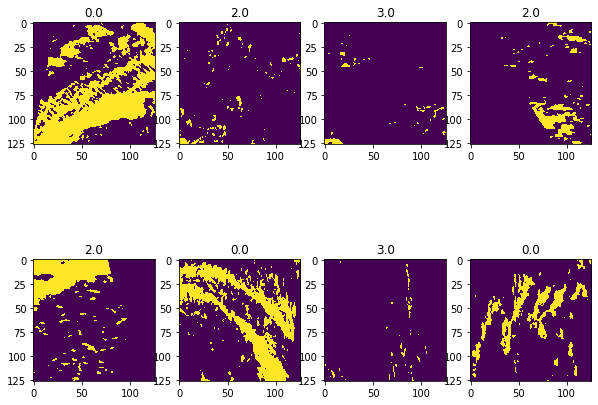

In [8]:
plt.figure(figsize=(10, 8))
for i in range(8):
    plt.subplot(2,4, i+1)
    plt.imshow(images[i+10])
    plt.title(labels_[i+10])

In [12]:
input_shape = 126*126 + 4; print(input_shape)
z = 32

# append labels to image data
# train_data = [(images[i].flatten(), labels_onehot[i])).reshape(1,-1) for i in range(len(images))]

15880


In [138]:
train_images = [images[i].reshape((1, 126, 126, 1)).astype(np.float32)
                for i in range(len(images))]

train_data = [(train_images[i], labels_onehot[i])
              for i in range(len(images))]

train_tensor = [tf.tuple(tf.convert_to_tensor(i),
                         tf.convert_to_tensor(k)) for i,k in train_data]
im_shape = (1, 126, 126, 1)

In [248]:
np.save("C:\\Users\\aresf\\Code\\datasets\\cloud_train_data.npy",
       train_data)

In [204]:
from sklearn.model_selection import train_test_split

x_train, x_test = train_test_split(train_data, test_size=0.33)

In [334]:
class Encoder(tf.keras.Model):
  def __init__(self, z):
    super(Encoder, self).__init__()
    self.latent_dim = z
    self.linear1 = tfk.layers.Dense(256, activation="relu")
    self.linear2 = tfk.layers.Dense(self.latent_dim, activation="relu")
    self.linear3 = tfk.layers.Dense(self.latent_dim + self.latent_dim)

  def call(self, x):
    x0 = tf.cast(tf.expand_dims(x[0], 0), tf.float32)
    x1 = tf.cast(tf.expand_dims(x[1], 0), tf.float32)
    y = self.linear1(x0)
    k = self.linear2(x1)
    ky = (tf.concat((y, k), -1))
    y = self.linear3(ky)
    return y

class CVAE(tf.keras.Model):
    def __init__(self, z):
        super(CVAE, self).__init__()
        self.latent_dim = z
        
        self.encoder = Encoder(z)
        self.decoder = tfk.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(self.latent_dim,)),
          tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
          tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
          tf.keras.layers.Conv2DTranspose(
              filters=128,
              kernel_size=3,
              strides=(3,3),
              padding="SAME",
              activation='relu'),
          tf.keras.layers.Conv2DTranspose(
              filters=64,
              kernel_size=3,
              strides=(3,3),
              padding="SAME",
              activation='relu'),
          # No activation
          tf.keras.layers.Conv2DTranspose(
              filters=1, kernel_size=3, strides=(2,2), padding="SAME"),
        ])


    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        
        return logits

In [335]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2.0 * np.pi)
    return tf.reduce_sum(
    -0.5 * ((sample - mean)**2.0 * tf.exp(-logvar) + logvar + log2pi),
    axis=raxis)
    
@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit,
                                                       labels=x[0])
    logpx_z = - tf.reduce_sum(cross_ent, axis=[1,2,3])
    logpz = log_normal_pdf(z, 0.0, 0.0)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return - tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    

In [336]:
epochs = 20
z = 64
num_examples = 16

random_gen_vector = tf.random.normal(
    shape=[num_examples, z])

model = CVAE(z)

In [337]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model.sample(test_input)
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

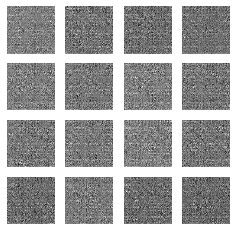

W0905 01:21:48.311933  3612 base_layer.py:1772] Layer encoder is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



ValueError: in converted code:

    <ipython-input-321-d62bac84e134>:25 compute_apply_gradients  *
        loss = compute_loss(model, x)
    c:\users\aresf\appdata\local\continuum\anaconda3\envs\tf2\lib\site-packages\tensorflow_core\python\eager\def_function.py:427 __call__
        self._initialize(args, kwds, add_initializers_to=initializer_map)
    <ipython-input-335-f9568a585d3f>:11 compute_loss  *
        mean, logvar = model.encode(x)
    <ipython-input-334-51dae7c2f43f>:54 encode  *
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    c:\users\aresf\appdata\local\continuum\anaconda3\envs\tf2\lib\site-packages\tensorflow_core\python\keras\engine\base_layer.py:807 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    <ipython-input-334-51dae7c2f43f>:14 call  *
        ky = (tf.concat((y, k), -1))
    c:\users\aresf\appdata\local\continuum\anaconda3\envs\tf2\lib\site-packages\tensorflow_core\python\util\dispatch.py:180 wrapper
        return target(*args, **kwargs)
    c:\users\aresf\appdata\local\continuum\anaconda3\envs\tf2\lib\site-packages\tensorflow_core\python\ops\array_ops.py:1431 concat
        return gen_array_ops.concat_v2(values=values, axis=axis, name=name)
    c:\users\aresf\appdata\local\continuum\anaconda3\envs\tf2\lib\site-packages\tensorflow_core\python\ops\gen_array_ops.py:1257 concat_v2
        "ConcatV2", values=values, axis=axis, name=name)
    c:\users\aresf\appdata\local\continuum\anaconda3\envs\tf2\lib\site-packages\tensorflow_core\python\framework\op_def_library.py:793 _apply_op_helper
        op_def=op_def)
    c:\users\aresf\appdata\local\continuum\anaconda3\envs\tf2\lib\site-packages\tensorflow_core\python\framework\func_graph.py:548 create_op
        compute_device)
    c:\users\aresf\appdata\local\continuum\anaconda3\envs\tf2\lib\site-packages\tensorflow_core\python\framework\ops.py:3429 _create_op_internal
        op_def=op_def)
    c:\users\aresf\appdata\local\continuum\anaconda3\envs\tf2\lib\site-packages\tensorflow_core\python\framework\ops.py:1773 __init__
        control_input_ops)
    c:\users\aresf\appdata\local\continuum\anaconda3\envs\tf2\lib\site-packages\tensorflow_core\python\framework\ops.py:1613 _create_c_op
        raise ValueError(str(e))

    ValueError: Shape must be rank 5 but is rank 2 for 'encoder/concat' (op: 'ConcatV2') with input shapes: [1,1,126,126,256], [1,64], [].


In [338]:
generate_and_save_images(model, 0, random_gen_vector)
import time
epochs = 3
for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in x_train:
    compute_apply_gradients(model, train_x, optimizer)
  end_time = time.time()

  if epoch % 1 == 0:
    loss = tf.keras.metrics.Mean()
    for test_x in x_test:
      loss(compute_loss(model, test_x))
    elbo = -loss.result()
    display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    elbo,
                                                    end_time - start_time))
    generate_and_save_images(
        model, epoch, random_gen_vector)

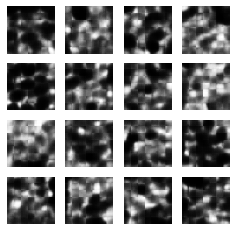

In [329]:
random_gen_vector = tf.random.normal(
    shape=[num_examples, z])
generate_and_save_images(model, -1, random_gen_vector)

In [332]:
ms = []
sds = []
lbls = []
for i in range(20):
    k = model.encode(x_test[i])
    ms.append(k[0].numpy())
    sds.append(k[1].numpy())
    lbls.append(np.argmax(x_test[i][1]))

means = np.squeeze(np.hstack(ms))
stds = np.squeeze(np.hstack(sds))
ls = np.repeat(np.hstack(lbls), 64)

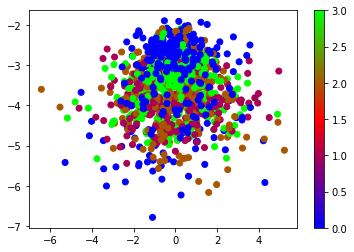

In [333]:
plt.scatter(means, stds, c=ls, cmap=custom_cmap)
plt.colorbar()

In [290]:
ls

array([0, 3, 2, 3, 3, 3, 0, 1, 2, 3, 1, 2, 2, 0, 2, 3, 1, 3, 0, 0],
      dtype=int64)

In [325]:
class CVAE(tf.keras.Model):
    def __init__(self, z):
        super(CVAE, self).__init__()
        self.latent_dim = z
        
        self.encoder = tfk.Sequential([
        tfk.layers.Lambda(lambda x: tf.expand_dims(
            tf.concat((tf.reshape(x[0],[-1]), x[1]), -1),0)),
        tfk.layers.Lambda(lambda x: tf.expand_dims(tf.reshape(x[0],[-1]), 0)),
        tfk.layers.Lambda(lambda x: tf.cast(x, tf.float32)),
        tfk.layers.Dense(256, activation="relu"),
        tfk.layers.
        tfk.layers.Dense(self.latent_dim+self.latent_dim)
        ])

        self.decoder = tfk.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(self.latent_dim,)),
          tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
          tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
          tf.keras.layers.Conv2DTranspose(
              filters=128,
              kernel_size=3,
              strides=(3,3),
              padding="SAME",
              activation='relu'),
          tf.keras.layers.Conv2DTranspose(
              filters=64,
              kernel_size=3,
              strides=(3,3),
              padding="SAME",
              activation='relu'),
          # No activation
          tf.keras.layers.Conv2DTranspose(
              filters=1, kernel_size=3, strides=(2,2), padding="SAME"),
        ])
        
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        
        return logits

In [261]:
from scipy.stats import norm

n = 64  # figure with 20x20 digits
digit_size = 126
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
#         z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = model.decode(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gnuplot2')
plt.show()  

InvalidArgumentError: Matrix size-incompatible: In[0]: [1,2], In[1]: [64,1568] [Op:MatMul]

In [299]:
means.shape

(1, 1280)